# Часть первая: перенос стиля при помощи pix2pix #
В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:
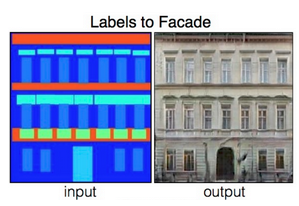


Датасет можно скачать [здесь](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz ) (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (Isola et al., 2016).

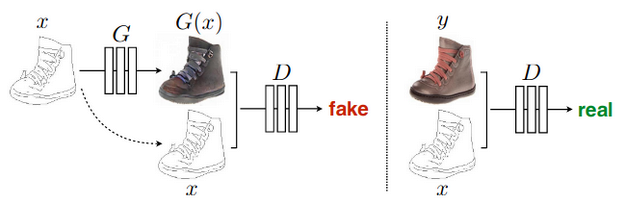

Источник: https://learnopencv.com/paired-image-to-image-translation-pix2pix/

In [2]:
from glob import glob
import itertools
import random

from PIL import Image
from IPython.display import display
from tqdm import tqdm

import numpy as np
import cv2

import albumentations as A
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [3]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz 
!tar -xf facades.tar.gz

--2021-12-18 16:59:09--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  2.62MB/s    in 9.3s    

2021-12-18 16:59:19 (3.08 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
IMG_HEIGHT = 256
IMG_WIDTH = 256


def read_image(image):        
        image = np.array(image)
        width = image.shape[1]
        width_half = width // 2
       
        input_image = image[:, :width_half, :]
        target_image = image[:, width_half:, :]
    
        input_image = input_image.astype(np.float32)
        target_image = target_image.astype(np.float32)
    
        return input_image, target_image


def random_crop(image, dim):
    height, width, _ = dim
    x, y = np.random.uniform(low=0,high=int(height-256)), np.random.uniform(low=0,high=int(width-256))  
    return image[:, int(x):int(x)+256, int(y):int(y)+256]

    
def random_jittering_mirroring(input_image, target_image, height=286, width=286):
    
    #resizing to 286x286
    input_image = cv2.resize(input_image, (height, width) ,interpolation=cv2.INTER_NEAREST)
    target_image = cv2.resize(target_image, (height, width),
                               interpolation=cv2.INTER_NEAREST)
    
    #cropping (random jittering) to 256x256
    stacked_image = np.stack([input_image, target_image], axis=0)
    cropped_image = random_crop(stacked_image, dim=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    input_image, target_image = cropped_image[0], cropped_image[1]
    #print(input_image.shape)
    if torch.rand(()) > 0.5:
     # random mirroring
        input_image = np.fliplr(input_image)
        target_image = np.fliplr(target_image)
    return input_image, target_image


def normalize(inp, tar):
    input_image = (inp / 127.5) - 1
    target_image = (tar / 127.5) - 1
    return input_image, target_image

In [6]:
class Train(object):
    def __call__(self, image):
        inp, tar = read_image(image)
        inp, tar = random_jittering_mirroring(inp, tar)
        inp, tar = normalize(inp, tar)
        image_a = torch.from_numpy(inp.copy().transpose((2,0,1)))
        image_b = torch.from_numpy(tar.copy().transpose((2,0,1)))
        return image_b, image_a

In [7]:
DIR = 'facades'
n_gpus = 4
batch_size = 8
global_batch_size = batch_size * n_gpus

train_ds = ImageFolder(DIR, transform=transforms.Compose([
        Train()]))
train_dl = DataLoader(train_ds, global_batch_size)


In [8]:
# custom weights initialization called on generator and discriminator
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

In [9]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        # construct unet structure
        # add the innermost block
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True) 
        #print(unet_block)

        # add intermediate block with nf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)

        # gradually reduce the number of filters from nf * 8 to nf. 
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        
        # add the outermost block
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [10]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [11]:
generator = UnetGenerator(3, 3, 64, norm_layer=nn.BatchNorm2d, use_dropout=False).cuda().float()
init_weights(generator, 'normal', scaling=0.02)
generator = torch.nn.DataParallel(generator)  # multi-GPUs

initialize network with normal


In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [13]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

In [14]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

In [15]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [16]:
discriminator = Discriminator(6, 64, 3, norm_layer=nn.BatchNorm2d).cuda().float()
init_weights(discriminator, 'normal', scaling=0.02)
discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

initialize network with normal


In [17]:
G_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [18]:
num_epochs = 200
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 
  

    D_loss_list, G_loss_list = [], []
   
    for (input_img, target_img), _ in train_dl:
       
        D_optimizer.zero_grad()
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # ground truth labels real and fake
        real_target = Variable(torch.ones(input_img.size(0), 1, 30, 30).to(device))
        fake_target = Variable(torch.zeros(input_img.size(0), 1, 30, 30).to(device))
        
        # generator forward pass
        generated_image = generator(input_img)
        
        # train discriminator with fake/generated images
        disc_inp_fake = torch.cat((input_img, generated_image), 1)
        
        D_fake = discriminator(disc_inp_fake.detach())
        
        D_fake_loss   =  discriminator_loss(D_fake, fake_target)
        
        # train discriminator with real images
        disc_inp_real = torch.cat((input_img, target_img), 1)
                                
        D_real = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(D_real,  real_target)

    
        
        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
        # compute gradients and run optimizer step
        D_total_loss.backward()
        D_optimizer.step()
        
        
        # Train generator with real labels
        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)                                 
        G_loss_list.append(G_loss)
        # compute gradients and run optimizer step
        G_loss.backward()
        G_optimizer.step()

In [19]:
val_ds = ImageFolder(DIR, transform=transforms.Compose([
        Train()]))
val_dl = DataLoader(val_ds, global_batch_size)

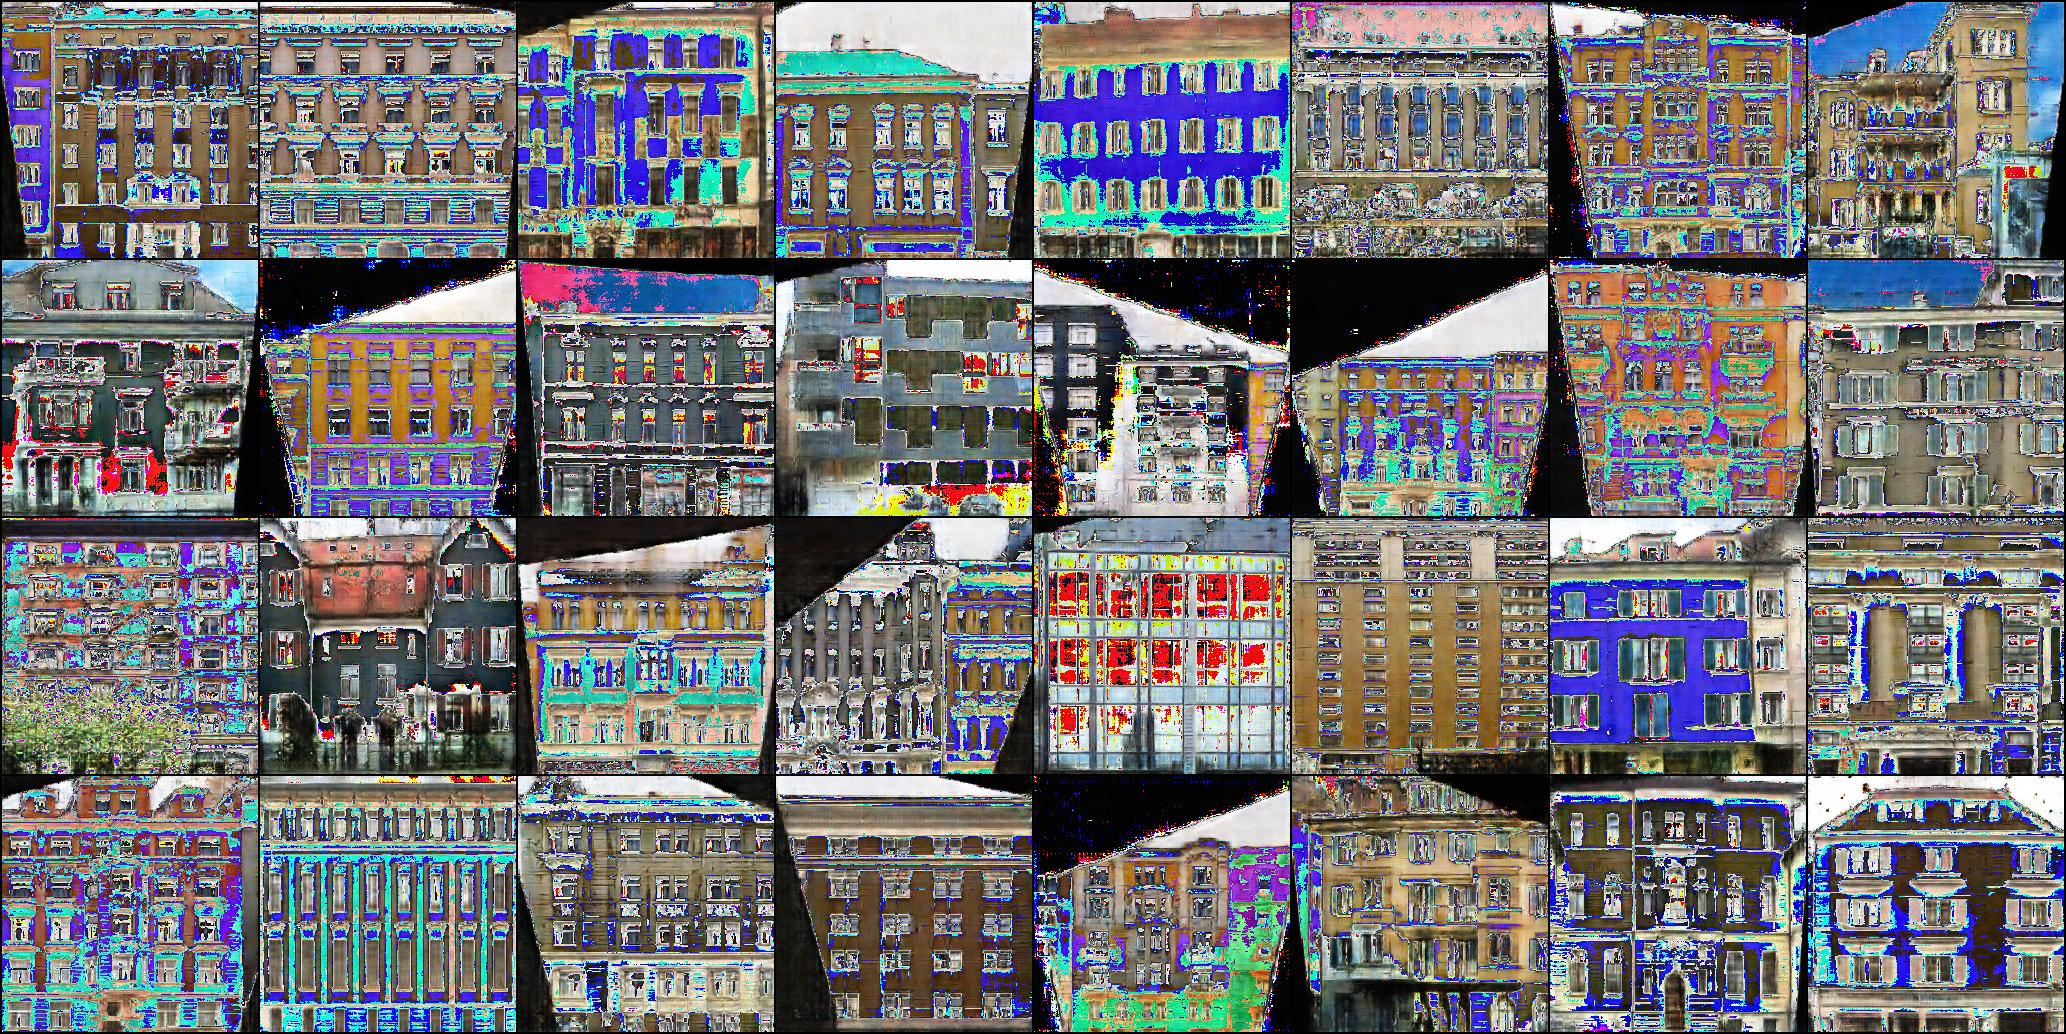

In [20]:
for (inputs, targets), _ in val_dl:
    inputs = inputs.to(device)
    generated_output =  generator(inputs)
    display(transforms.ToPILImage()(utils.make_grid(generated_output.data)))
    break